## Тимонин Сергей
### Вариант 2
_______________________

# Задание 1. A/B–тестирование
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?
- Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

In [2]:
import pandas as pd 
import numpy as np
import requests 
from urllib.parse import urlencode 
from IPython.display import display_html
from itertools import chain, cycle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tqdm.auto import tqdm
import plotly.express as px
import plotly.subplots as sp


In [3]:
# функция для автоматического обновления данных с Яндекс Диска
def ya_url(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    return download_url

# подгружаем все файлы
groups_add = pd.read_csv(ya_url('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'), sep=',') 
groups = pd.read_csv(ya_url('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';') 
active = pd.read_csv(ya_url('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'), sep=';') 
checks = pd.read_csv(ya_url('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';') 

### Шаг 1. Подготовка и просмотр файлов
Перед тем как приступить к самому А/В тесту, посмотрим, что за данные были предоставлены, проверим их объем, дубликаты, пустые значения.

In [12]:
# Из-за ошибки KeyError: 'href' (исчерпан лимит скачиваний файла) подгружу данные вручную, 
# можно было оставить, думаю этот впорос не принципиально важен 
# groups_add = pd.read_csv('Проект_2_group_add.csv', sep=',') 
# groups = pd.read_csv('Проект_2_groups.csv', sep=';') 
# active = pd.read_csv('Проект_2_active_studs.csv', sep=';') 
# checks = pd.read_csv('Проект_2_checks.csv', sep=';') 

In [4]:
# посмотрим на все дата фреймы, что вообще за данные нас ожидают
# чтобы не раздувать место для показа всех 4-ех df, применю функцию, которая разместить их на 1 строке
def display_side_by_side(*args, titles=cycle([''])):
    html_str = ''
    for df, title in zip(args, chain(titles, cycle(['</br>']))):
        html_str += '<th style="text-align:center"><td style="vertical-align:top">'
        html_str += f'<h2 style="text-align: center;">{title}</h2>'
        html_str += df.to_html().replace('table', 'table style="display:inline"')
        html_str += '</td></th>'
    display_html(html_str, raw=True)

In [5]:
# Просмотр всех предоставленных DataFrame
display_side_by_side(groups_add.head(5), groups.head(5), active.head(5), checks.head(5),
                     titles=['groups_add', 'groups', 'active', 'checks'])

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B


In [6]:
# Так как структура данных у groups_add и groups иднетична, объединяю их в один df
groups_total = pd.concat([groups_add, groups])

In [7]:
display_side_by_side(groups_total.head(5), active.head(5), checks.head(5),
                     titles=['groups_total', 'active', 'checks'])

groups_total 
 
 
 
 id 
 grp 
 
 
 
 
 0 
 5694584 
 B 
 
 
 1 
 5694830 
 B 
 
 
 2 
 5695057 
 B 
 
 
 3 
 5698872 
 B 
 
 
 4 
 5699067 
 B 
 
 
 active 
 
 
 
 student_id 
 
 
 
 
 0 
 581585 
 
 
 1 
 5723133 
 
 
 2 
 3276743 
 
 
 3 
 4238589 
 
 
 4 
 4475369 
 
 
 checks 
 
 
 
 student_id 
 rev 
 
 
 
 
 0 
 1627 
 990.0 
 
 
 1 
 3185 
 690.0 
 
 
 2 
 25973 
 690.0 
 
 
 3 
 26280 
 690.0 
 
 
 4 
 100300 
 990.0

In [8]:
# Посмотрим количество строк и столбцов в каждом DataFrame
print('Groups_total: строк и столбцов:', groups_total.shape)  # Дополнительно проверю, чтобы конкатенация прошла успешно
print('Groups_add: строк и столбцов:', groups_add.shape)
print('Groups: строк и столбцов:', groups.shape)
print('Active: строк и столбцов:', active.shape)
print('Checks: строк и столбцов:', checks.shape)

Groups_total: строк и столбцов: (74576, 2)
Groups_add: строк и столбцов: (92, 2)
Groups: строк и столбцов: (74484, 2)
Active: строк и столбцов: (8341, 1)
Checks: строк и столбцов: (541, 2)


In [9]:
# Проверка наличия дубликатов в каждом DataFrame
print('Groups_total: проверка дубликатов:', groups_total.duplicated().any())
print('Groups_add: проверка дубликатов:', groups_add.duplicated().any())
print('Groups: проверка дубликатов:', groups.duplicated().any())
print('Active: проверка дубликатов:', active.duplicated().any())
print('Checks: проверка дубликатов:', checks.duplicated().any())

Groups_total: проверка дубликатов: False
Groups_add: проверка дубликатов: False
Groups: проверка дубликатов: False
Active: проверка дубликатов: False
Checks: проверка дубликатов: False


In [10]:
# Посмотрим на наличие пустых ячеек
print('Groups_total: проверка пустых ячеек:', groups_total.isna().sum())
print('Groups_add: проверка пустых ячеек:', groups_add.isna().sum())
print('Groups: проверка пустых ячеек:', groups.isna().sum())
print('Active: проверка пустых ячеек:', active.isna().sum())
print('Checks: проверка пустых ячеек:', checks.isna().sum())

Groups_total: проверка пустых ячеек: id     0
grp    0
dtype: int64
Groups_add: проверка пустых ячеек: id     0
grp    0
dtype: int64
Groups: проверка пустых ячеек: id     0
grp    0
dtype: int64
Active: проверка пустых ячеек: student_id    0
dtype: int64
Checks: проверка пустых ячеек: student_id    0
rev           0
dtype: int64


### Шаг 2. Работа внутри DataFrame
Ок, данные выверены по ним вопросов нет, далее определяю метрики, которые буду прорабатывать. Так как я сначала выполнил задания 2 и 3, только потом приступил к 1-му, поэтому набор метрик будет такой-же как и во 2 и 3 заданиях, а именно:
- ARPU - (Average Revenue Per User), т.е. средний доход на пользователя
- ARPPU - (Average Revenue Per Paying User), т.е. средний чек платящего на пользователя


In [23]:
# Создаем колонки с признаками активного и платящего пользователя
active['status_active'] = 1
checks['status_rev'] = 1

# Переименовываем столбцы для удобства слияния и объединения всех DataFrame
active = active.rename(columns={'student_id': 'id'})
checks = checks.rename(columns={'student_id': 'id'})

# Объединяем все DataFrame
df_t1 = groups_total.merge(checks, how='left', on='id').merge(active, how='left', on='id')
df_t1 = df_t1.fillna(0)
df_t1 = df_t1.query("status_active == 1")

Итак, так как были определены метрики ARPU и ARPPU теперь посмотрю общие данные по ним

In [24]:
# Группировка и агрегация данных в df_t1
df_agg_t1 = df_t1.groupby(['grp'], as_index=False). \
    agg({'rev': 'sum', 'id': 'count', 'status_rev': 'sum', 'status_active': 'sum'}). \
    rename(columns={'id': 'count_id', 'status_rev': 'count_id_with_payment',
                    'status_active': 'count_active_id'})


# Расчет метрик ARPU, ARPPU 
df_agg_t1['ARPU'] = df_agg_t1['rev'] / df_agg_t1['count_id']
df_agg_t1['ARPPU'] = df_agg_t1['rev'] / df_agg_t1['count_id_with_payment']


df_agg_t1

,grp,rev,count_id,count_id_with_payment,count_active_id,ARPU,ARPPU
0,A,72820.0000,1538,78.0,1538.0,47.347204,933.589744
1,B,394974.0035,6803,314.0,6803.0,58.058798,1257.878992


Стоит отметить, что две выборки (группы A и B) существенно отличаются по размеру, что может вызывать сомнения относительно адекватности статистической оценки различий. В таких случаях необходимо тщательно проанализировать результаты и учитывать особенности каждой выборки при интерпретации результатов тестирования.

- в группе **А** 1 538 пользователя (18,4%)
- в группе **В** 6 803 пользователя (81,6%)

Хоть и Анатолий Карпов говорит, что это и частая практика при проведение тестирования, но всё равно хотелось бы заострить внимание на данном факте.

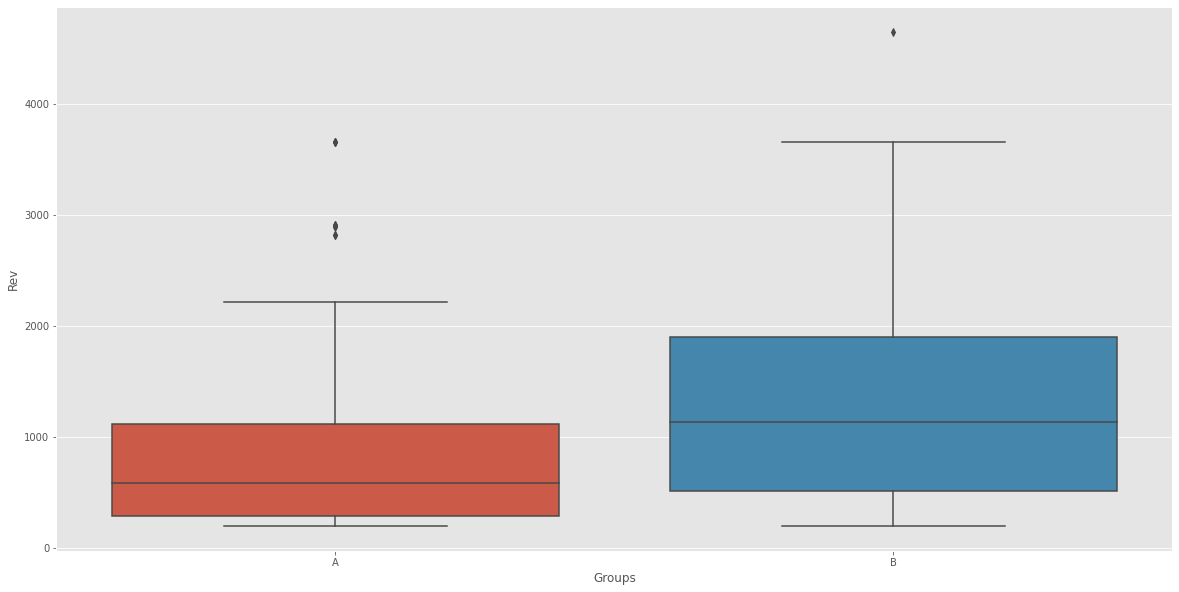

In [25]:
# визузализируем, чтобы проверить средние по ARPPU и посомтреть наличие выбросов
df_filtered = df_t1[(df_t1.status_rev == 1)].sort_values('grp')
plt.figure(figsize=(20, 10))
sns.boxplot(x='grp', y='rev', data=df_filtered)
plt.xlabel('Groups')
plt.ylabel('Rev')
plt.show()

Боксполты свитедельствуют о наличие выбросов.

### Шаг 3. Приступаю к А/В тестированию.
Формулирую нулевую и альтернативную гипотезы:
- H0 (нулевая гипотеза): Нет статистически значимой разницы между данными группами.
- H1 (альтернативная гипотеза): Соответственно, статистически значимая разница существует.

Напоминаю, что в качестве основной базы для тестирования, были отобраны активные пользователи.

In [26]:
# отделяем df Для тестирования
data = df_t1

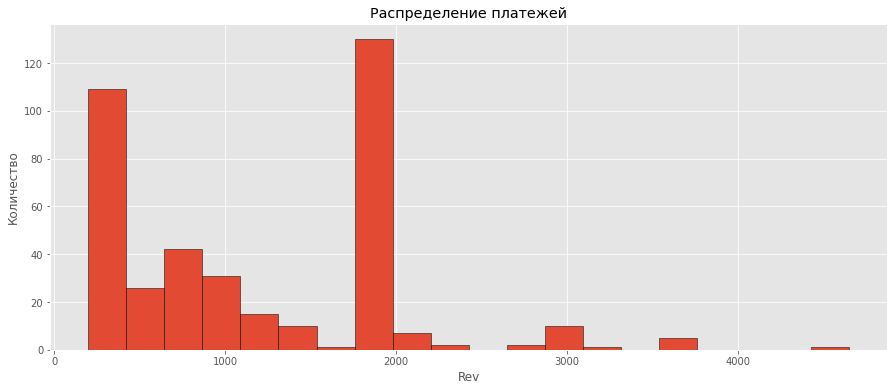

In [27]:
# Визуализация распределения платежей для определения выбора теста
df_graf = data[data['status_rev'] == 1]

plt.figure(figsize=(15, 6)) 
plt.hist(df_graf['rev'], bins=20, edgecolor='black')
plt.xlabel('Rev') 
plt.ylabel('Количество') 
plt.title('Распределение платежей') 
plt.show() 

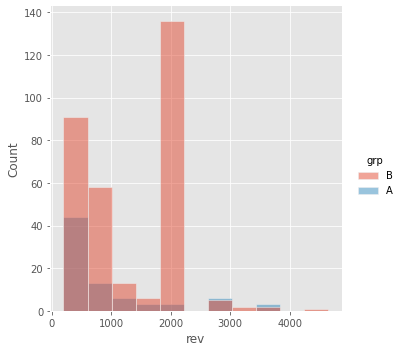

In [28]:
# посмотрим на распеределение платежей, чтобы опрделиться каким именно тестом пользоваться.
sns.displot(data=data.query("status_rev ==1"), x="rev", hue="grp")

## Шаг 4. Выбор методики: Так как распределение не является нормальным и было выявлено явное различие в размерах выборок, в качестве одного из методов оценки, можно применить Bootstrap.  


Для этого:
1. Подготавлиеваем данные
2. Определяем и расчитываем метрики
3. Определяем количество повторений/выборок (чем больше, тем выше точность результатов)
4. Генерируем выборки
5. Рассчитываем метрики по выборкам
6. Вычисляем наблюдаемую статистику (из оригинальных данных) 
7. Вычисляем статистику на основе сгенерированныз выборок/перестановок
8. Получаем p-value

In [20]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,  # чтобы сохранить дисперсию, берем такой же размер выборки
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

### Проверяем ARPU

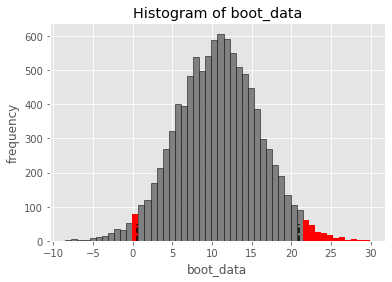

In [29]:
booted_data_arpu = get_bootstrap(
    data[data.grp == "B"].rev,  # числовые значения первой выборки
    data[data.grp == "A"].rev,  # числовые значения второй выборки
    boot_it=10000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95)  # уровень значимости

In [30]:
booted_data_arpu["p_value"]

0.03834568741295613

**P-value по ARPU составляет 3.8%:**
что говорит о наличие статистической значимости, в соответствие с чем, **отклоняем H0**

### Проверяем ARPPU

In [31]:
df_arppu = df_t1.query('status_rev != 0')

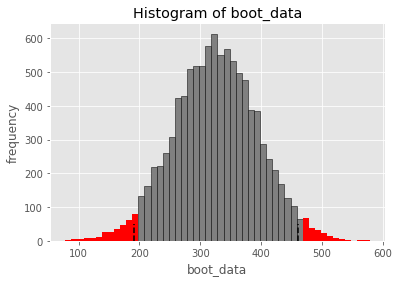

In [32]:
booted_data_arppu = get_bootstrap(
    df_arppu[df_arppu.grp == "B"].rev,  # числовые значения первой выборки
    df_arppu[df_arppu.grp == "A"].rev,  # числовые значения второй выборки
    boot_it=10000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95)  # уровень значимости

In [33]:
booted_data_arppu["p_value"]

2.2098768760111306e-06

**P-value по ARPPU около 0:**
что говорит о наличие статистической значимости, в соответствие с чем, **отклоняем H0**

### Исходя из предоставленных выше p-value для метрик ARPU и ARPPU можно сделать следующие выводы:
  
  
**ARPU:**
- P-value = 3.8% (менее 5%)
- Так как p-value меньше обычно выбранного уровня значимости (5%), можно считать результаты статистически значимыми. Следовательно, существует статистически подтвержденное различие в средней оплате на пользователя между группами A и B.

**ARPPU:**
- P-value = 2.2098768760111306e-06 (очень близко к нулю).
- Очень низкое p-value говорит о том, что различие в средней оплате на платящего пользователя между группами A и B является статистически значимым. Это подразумевает, что существует значительное и статистически подтвержденное различие в оплате среди платящих пользователей между группами.

**Общий вывод:**
На основе анализа p-value для указанных метрик можно заключить, что между группами A и B существует статистически значимое различие в средних суммах оплат пользователей в дни проведения эксперимента. Все метрики менее  0,05 и демонстрируют статистически значимые различия, а следовательно применить новую механику оплаты.

----------------------------------

-----------------------------

# Задание 2. SQL
### 2.1 Очень усердные ученики.
#### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. 
Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов. Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

#### 2.1.2 Задача
Дана таблица *default.peas*:

| Название атрибута | Тип атрибута   | Смысловое значение   |
|------|------|------|
|   st_id  | int| ID ученика|
|   timest  | timestamp| Время решения карточки|
|   correct  | bool| 	Правильно ли решена горошина?|
|   subject  | text| Дисциплина, в которой находится горошина|

#### Решение:
Так как в задание указано, что данные нужно смотреть за "текущий месяц", а в таблице только данные за 2021 год, оставлю выбор года и месяца за пользователем.

In [ ]:
--создаю таблицу с подсчетом количества горошин, а также указываю интересующий месяц и год
with t_table as
( 
select st_id, count (correct) as kolvo_gorosh
from default.peas
where correct = TRUE 
  and extract(year from timest) = 2021
  and extract(month from timest) = 10
group by st_id
)
--обращаюсь к созданной таблице и оставляю студентов, у которых более 20 горошин
select count(*) 
from t_table
where kolvo_gorosh > 20

**Ответ**: 130 учеников

### 2.2 Оптимизация воронки
#### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

#### 2.2.2 Задача

Дана таблицы: *default.peas* (см. выше), *default.studs*:

| Название атрибута | Тип атрибута   | Смысловое значение   |
|------|------|------|
|   st_id  | int| ID ученика|
|   test_grp  | text|  Метка ученика в данном эксперименте|

и *default.final_project_check*:

| Название атрибута | Тип атрибута   | Смысловое значение   |
|------|------|------|
|   st_id  | int| ID ученика|
|   sale_time  | timestamp| Время покупки|
|   money  | int| Цена, по которой приобрели данный курс|
|   subject  | text| |

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- **ARPU**  

- **ARPAU** 
 
- **CR в покупку** 

- **СR активного пользователя в покупку** 

- **CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике**

**Важно, что:**

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

Разберемся в терминологии:
- **ARPU**  - (Average Revenue Per User), т.е. средний доход на пользователя

- **ARPAU** - (Average Revenue Per Active User), т.е.  средний доход от каждого активного пользователя, в нашем случае пользователей, которые решили больше 10 задач правильно
 
- **CR в покупку** - % пользователей, которые купили полный доступ

- **СR активного пользователя в покупку** - % активных пользователей, которые купили полный доступ, в нашем случае пользователей, которые решили больше 10 задач правильно

- **CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике**


In [ ]:
with t_table as 
(
select s.st_id, fp.st_id, s.test_grp, fp.money, p.subject, fp.sale_time,
    sum(p.correct) > 10 as active_user, --проставляю признак 1 на пользователей, выполнивших большее 10 задач
    sum(case when p.subject = 'Math' and p.correct = 1 then 1 else 0 end) >= 2 as math_user -- проставляю признак 1 на пользователей, выполнивших большее 2 задач по Math
from default.studs s
    left join default.final_project_check fp on s.st_id = fp.st_id
    left join default.peas p on s.st_id = p.st_id
group by  s.st_id, fp.st_id, s.test_grp, fp.money, p.subject, fp.sale_time
)

select s.test_grp, 
    round(avg(fp.money),2) as ARPU,
    round(avg(case when t_table.active_user then fp.money end), 2) as ARPAU,
    round(count(distinct fp.st_id) / count(distinct s.st_id) * 100,2)as CR,
    round(count(distinct case when t_table.active_user and fp.st_id is not null then fp.st_id end) / count(distinct case when t_table.active_user then s.st_id end) * 100,2)  as CR_active_user,
    round(count(distinct case when t_table.math_user and fp.st_id is not null then fp.st_id end) / count(distinct case when t_table.math_user then s.st_id end) * 100,2) as CR_math_user
from t_table
group by s.test_grp

---------------------------------  

---------------------------- 

# Задание 3. Python
## 3.1 Задача

- Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного **файла groups_add.csv (заголовки могут отличаться)** и на основании дополнительных параметров пересчитывать метрики.
- Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Так как  нет упоминаний какие именно метрики необходимо считать метрики, буду считать:
- **ARPU**-(Average Revenue Per User), т.е. средний доход на пользователя
- **ARPPU** -(Average Revenue Per Paying User), т.е. средний доход на платящего пользователя
- **CR**    -(Сonversion rate), т.е. коэффициент конверсии

*Напоминание по структуре файлов:*
- *groups.csv -  файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)* 
- *groups_add.csv -  дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных*
- *active_studs.csv -  файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента*
- *checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента*

#### Часть 1.  Создание функции, которая будет получать обновленные данные из файла groups_add расчитывать необходимые метрики.

In [35]:
# функция для автоматического обновления данных с Яндекс Диска
def ya_url(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    return download_url

# подгружаем все файлы
groups_add = pd.read_csv(ya_url('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'), sep=',') 
groups = pd.read_csv(ya_url('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';') 
active = pd.read_csv(ya_url('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'), sep=';') 
checks = pd.read_csv(ya_url('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';') 

In [49]:
def task_3(groups, active, checks):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ' 
    # получаю url 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    groups_add = pd.read_csv(download_url, sep=',') 
    # решаю проблему с изменчивостью заголовков через индекс
    groups_add = pd.read_csv('Проект_2_group_add.csv', sep=',')  # потом удалить эту строку (как запустится яндекс)
    groups_add.rename(columns=({groups_add.columns[0]: 'id', groups_add.columns[1]: 'grp'}), inplace=True) 
    # объединяю два два файла с пользователями
    groups_total = pd.concat([groups_add, groups])
    # переименовываю столбцы чтобы было удобно сцепить и делаю merge всех таблиц
    active = active.rename(columns={'student_id': 'id'})
    checks = checks.rename(columns={'student_id': 'id'})
    active['status_active'] = 1  # доп поле для расчета активных пользователей
    checks['status_rev'] = 1  # доп поле для расчета оплативших пользователей
    df = groups_total.merge(checks, how='left', on='id').merge(active, how='left', on='id')
    df = df.fillna(0)
    df_agg = df.groupby(['grp'], as_index=False). \
        agg({'rev': 'sum', 'id': 'count', 'status_rev': 'sum', 'status_active': 'sum'}). \
        rename(columns={'id': 'count_id', 'status_rev': 'count_id_with_payment'})

    df_agg['ARPU'] = df_agg['rev'] / df_agg['count_id']
    df_agg['ARPPU'] = df_agg['rev'] / df_agg['count_id_with_payment']
    df_agg['CR'] = df_agg['count_id_with_payment'] / df_agg['count_id'] * 100
    return df_agg

In [50]:
task_3(groups, active, checks)

,grp,rev,count_id,count_id_with_payment,status_active,ARPU,ARPPU,CR
0,A,92096.0000,14693,107.0,1538.0,6.268019,860.710280,0.728238
1,B,481230.0036,59883,434.0,6803.0,8.036171,1108.824893,0.724747


#### Часть 2. Создание функции, которая будет создавать графики с метриками исходя из первой функции.

In [51]:
def task_3_visual(df_agg):

    fig1 = px.bar(df_agg, x='grp', y='ARPU', title='ARPU ')
    fig2 = px.bar(df_agg, x='grp', y='ARPPU', title='ARPPU')
    fig3 = px.bar(df_agg, x='grp', y='CR', title='CR')
    # Создаю сетку для графиков
    fig = sp.make_subplots(rows=1, cols=3, subplot_titles=('ARPU', 'ARPPU', 'CR'))
    # Добавляю графики на сетку
    fig.add_trace(fig1.data[0], row=1, col=1)
    fig.add_trace(fig2.data[0], row=1, col=2)
    fig.add_trace(fig3.data[0], row=1, col=3)

    # Убираю фон
    fig.update_layout(
        showlegend=False, 
        title_text='APRU, ARPPU и CR пользователей групп А и В',
        title_x=0.5,
        plot_bgcolor='white', 
        paper_bgcolor='white' 
    )
    fig.update_traces(marker_color='blue', row=1, col=3)
    fig.show()

In [52]:
task_3_visual(task_3(groups, active, checks))